In [1]:

import numpy as np

import ngsolve 
from ngsolve.webgui import Draw
import netgen.geom2d

# Exploring Gray Scott in 2d-FEM

In [107]:
# Reaction parts of differential equations for 
# different types of different Reaction diffusion equations
# u,v are scalar fields, alpha, beta could be numbers or arrays with same dimension as fields
# rdtype is a string specifying the model
def Reaction(u,v,alpha,beta,rdtype):
    if (rdtype == 'FN'):  # FitzHugh Nagumo model
        Ru,Rv=R_FN(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Br'):  # Brusellator model
        Ru,Rv= R_Br(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'GS'):  # Gray-Scott model
        Ru,Rv = R_GS(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Ba'):   # Barkley model 
        epsilon = 0.02  # choosing this value
        Ru,Rv = R_Ba(u,v,alpha,beta,epsilon)
        return Ru,Rv
    if (rdtype == 'Heat'):  # Heat equation 
        n = len(u)
        Ru = np.zeros(n); Rv = np.zeros(n)
        return Ru,Rv
    print('invalid reaction type')

#The FitzHugh-Nagumo Reaction Diffusion Model
# example: Du, Dv, alpha, beta = 1, 10, 0.1, 1, dt=0.01, dx = 1
def R_FN(u,v,alpha,beta): 
    Ru =  u - u**3 - v + alpha 
    Rv = (u - v)*beta
    return Ru,Rv
    
# Brusselator Reaction Diffusion model
# example: Du, Dv, alpha, beta = 2, 22, 5, 9 # dt=0.005, dx=1
# u = alpha, v = beta/alpha is a fixed point of R
def R_Br(u,v,alpha,beta): 
    Ru = alpha - (beta+1)*u + (u**2)*v    
    Rv = beta*u - (u**2)*v
    return Ru,Rv

# The Gray-Scott Reaction Diffusion model
# alpha is feed rate for u and kills v, beta is kill or drain rate for v
# example: Du = 0.2, Dv = Du/2, alpha = 0.037 and beta = 0.06 , dx=1
def R_GS(u,v,alpha,beta): 
    Ru =  -u*(v**2) + alpha*(1-u) 
    Rv =  u*(v**2) -(alpha+ beta)*v
    return Ru,Rv

# the Barkley model 
# http://www.scholarpedia.org/article/Barkley_model
# example epsilon=0.02, alpha = 0.75, beta = 0.02, domain = 200, dt = 0.01
def R_Ba(u,v,alpha,beta,epsilon): 
    Ru =  (1/epsilon)*u*(1-u)*(u - (v + beta)/alpha) 
    Rv =  u-v
    return Ru,Rv

In [4]:
# https://docu.ngsolve.org/latest/i-tutorials/unit-4.1.2-csg2d/csg2d.html
geo = netgen.geom2d.CSG2d()

# make a circle with a hole in it!
circle1 = netgen.geom2d.Circle( center=(0,0), radius=1.0,  bc="outer" )
circle2 = netgen.geom2d.Circle( center=(0.1,0), radius=0.3,  bc="inner" )

annulus = circle1 - circle2
geo.Add(annulus)

# generate the  mesh
maxh_mesh = 0.03  # max distance between nodes?
mesh = ngsolve.Mesh(geo.GenerateMesh(maxh=maxh_mesh))  # maxh here sets the scale of elements 
print(f"vertices={mesh.nv}, edges ={mesh.ne}")  # print numbers of vertices and edges!

Draw(mesh) # show the mesh

vertices=3551, edges =6830


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [77]:
# create finite element system 'fes'  - we have two fields for the reaction diffusion equations 
korder = 3
Q1 = ngsolve.H1(mesh, order=korder)   # Choose an element that is in the Sobolev space H1, first field
Q2 = ngsolve.H1(mesh, order=korder)   # second field
fes = Q1*Q2   # our finite element space is the product of the two spaces 
#(u1,u2),(v1,v2)  = fes.TnT()  # create test and trial functions  
# The two test fields are u1,u2 and the trial functions are v1,v2
# in our equations the fields were u,v but here we have u=u1 and v=u2     
# in our equations the trial functions were both w, and here they are v1 and v2

#gfu = ngsolve.GridFunction(fes) # to hold the solution 

# output fields 
#u1_out = gfu.components[0]
#u2_out = gfu.components[1]

In [70]:
# create operators 
def mkops(fes,D_u,D_v,dt):
    (u1,u2),(v1,v2)  = fes.TnT() 
    a = ngsolve.BilinearForm(fes)  # holds Laplacian operator for both fields 
    a += 1*D_u*ngsolve.grad(u1)*ngsolve.grad(v1)*ngsolve.dx # This is laplacian with a diffusion coef on the first field
    a += 1*D_v*ngsolve.grad(u2)*ngsolve.grad(v2)*ngsolve.dx # second field
    a.Assemble()

    m = ngsolve.BilinearForm(fes)  # hold mass matrix for both fields 
    m += u1*v1*ngsolve.dx + u2*v2*ngsolve.dx
    m.Assemble()

    im = m.mat.CreateMatrix()
    invm = im.Inverse(freedofs=fes.FreeDofs())  

    #print(f"m.mat.nze = {m.mat.nze}, a1.mat.nze={a.mat.nze}") # check that they are the same
    # these are the number of nonzero elements in the sparse matrices

    # B = M - 0.5*L*dt , needed for Crank Nicholson update L = Laplacian times diffusion coeff, M = mass matrix
    b = m.mat.CreateMatrix()
    b.AsVector().data     = m.mat.AsVector() - 0.5*dt * a.mat.AsVector()
    #print(f"b.nze = {b.nze}")

    # A* = M + 0.5 * L * dt   needed for Crank Nicholson update 
    astar = m.mat.CreateMatrix() # create a matrix in the form of m
    astar.AsVector().data = m.mat.AsVector() + 0.5*dt * a.mat.AsVector()
    invastar = astar.Inverse(freedofs=fes.FreeDofs())
    #print(f"astar.nze={astar.nze}")
    return invastar,a,b,invm


In [7]:

D_u  = 5.0e-5;   D_v = D_u/2 #diffusion coefficients 
dt = .5    # timestep 
rdtype = 'GS'   # doing a Gray Scott reaction diffusion model 
print(maxh_mesh**2/D_u,maxh_mesh**2/D_v )  # both of these should be larger than dt
# this is a CFL like condition for numerical stability
# CHECK that our dt is lower than these !!!!!!


18.0 36.0


In [132]:
# create initial conditions!
# set initial conditions into gfu
# parameters:
#  gfu is output grid function
#  sig0: width of random uniform initial conditions 
#  u0, v0 constant offsets for initial conditions
#  h:  width of seed points
# returns: nothing
def mkinit(gfu,mesh,sig0,nseeds,h):

    # output fields 
    u1_out = gfu.components[0]
    u2_out = gfu.components[1]

    #sig0 = 0.1; # width of uniform random distn 
    #mu0=sig0/2 # shift mean to this value 

    r1  = u1_out.vec.CreateVector()  # create two vectors 
    r2  = u1_out.vec.CreateVector()

    r1.SetRandom(); # fill with random numbers probably between 0 and 1
    r2.SetRandom(); 
    r1 = sig0*r1  # scale by sig0
    r2 = sig0*r2

    #u1_out.Set(1.0)  # set to 1
    #u2_out.Set(v0)  # set to a constant 

    ccf_v = ngsolve.CF(0.0)  #  a coefficient function 
    ccf_u = ngsolve.CF(1.0)   

    # use the bounding box to find min and max range of x and y values 
    netgen_mesh = mesh.ngmesh
    p1,p2 = netgen_mesh.bounding_box
    #print(p1,p2)
    xxmin = min(p1[0],p2[0])
    xxmax = max(p1[0],p2[0])
    yymin = min(p1[1],p2[1])
    yymax = max(p1[1],p2[1])

    # seed with some 1 values 
    #xxmin = -1; xxmax = 1;  # max min ranges for domain, set by hand 
    #yymin = -1; yymax = 1
    #maxhval = 0.01
    for k in range(nseeds):
        x_p = np.random.uniform(xxmin,xxmax)  # random position
        y_p = np.random.uniform(yymin,yymax)
        rr2 = (ngsolve.x - x_p)*(ngsolve.x - x_p) + (ngsolve.y - y_p)*(ngsolve.y - y_p)
        ccf_v += 0.4*ngsolve.exp(-0.5*rr2/h**2)  # creates a coefficient function 
        
    u2_out.Set(ccf_v) 

    for k in range(nseeds):
        x_p = np.random.uniform(xxmin,xxmax)  # random position
        y_p = np.random.uniform(yymin,yymax)
        rr2 = (ngsolve.x - x_p)*(ngsolve.x - x_p) + (ngsolve.y - y_p)*(ngsolve.y - y_p)
        ccf_u += -0.5*ngsolve.exp(-0.5*rr2/h**2)  # creates a coefficient function 

    u1_out.Set(ccf_u) 

    # add random stuff to initial fields 
    #u1_out.vec.data += r1   
    # something wrong with projector when there is no Dirichlet BC
    u2_out.vec.data += r2 # ngsolve.Projector(fes.FreeDofs(), True) * r2 
    # projector means don't touch Dirichlet boundary 
   


In [137]:
# arguments:
#  fes:  finite element space
#  gfu :     # for holding solution, is a Gridfunction on a predefined mesh
#  scene:   Webgui draw
#  invastar, a_lap,invm :      # matrix operators on the finite element system 
#  nsamples:  number of outputs to store in the multidimensional data set 
#  rdtype: type of Reaction diffusion equation, is a string
#  alpha, beta: parameters for the reaction diffusion equation 
#  dt:        timestep  which is used in the matrix operators invastar and b 
#  reaction_by_hand:  how reactions are applied  (True/False)
# returns 
#  gfut:   a multidimensional set of grid functions on finite element system that holds time stepped results
# globals: 
#   Reaction() if reaction_by_hand = True
def TimeStepping_CN(fes,gfu, scene, invastar, a_lap, invm, rdtype, alpha, beta, dt, initial_cond = None, t0 = 0, tend = 10, 
                 nsamples = 20,reaction_by_hand = False):
    
    if initial_cond:
        gfu.Set(initial_cond)   # set initial condition, otherwise don't touch the initial fields 
        # as the initial condition could be set already in gfu.vec.data
    cnt = 0; time = t0
    sample_int = int(np.floor(tend / dt / nsamples)+1)  # nsamples seems to be the number of outputs we want
    
    gfut = ngsolve.GridFunction(gfu.space,multidim=0)
    gfut.AddMultiDimComponent(gfu.vec)  #  so we can store a series of solutions 
    
    # create a nonlinear operator for the reactions
    if (reaction_by_hand==False):
        (u1,u2),(v1,v2)  = fes.TnT()  #
        reaction_op =  ngsolve.BilinearForm(fes, nonassemble=True)
        if (rdtype=='Br'):
            Ru = (alpha*v1 - (beta+1)*u1 + u1*u1*u2 )*v1
            Rv = (beta*u1 - u1*u1*u2)*v2
            # Ru = alpha - (beta+1)*u + (u**2)*v    becomes alpha - (beta+1)*u1  + u1^2 * u2 for the Brusselator!
            # Rv = beta*u - (u**2)*v
        if (rdtype=='GS'):
            Ru = (alpha*(1-u1) - u1*u2*u2 )*v1
            Rv = (u1*u2*u2 - (alpha + beta)*u2 )*v2 
            #Ru =  -u*(v**2) + alpha*(1-u)  Gray Scott 
            #Rv =  u*(v**2) -(alpha+ beta)*v
        if (rdtype=='FN'):
            Ru = (u1 - u1*u1*u1 - u2 + alpha )*v1
            Rv = (u1 - u2)*beta*v2 
            #Ru =  u - u**3 - v + alpha   Fitzhugh Nagumo
            #Rv = (u - v)*beta
        reaction_op += Ru*ngsolve.dx + Rv*ngsolve.dx
    else: # we need storage vecs
        gfu_temp = ngsolve.GridFunction(fes)
        res_u = gfu.components[0].vec.CreateVector()
        res_v = gfu.components[1].vec.CreateVector()

    res = gfu.vec.CreateVector() # is a base vector 
    
    if (fes.ndof == np.sum(fes.FreeDofs())):
        Dir_BC = False  # there is no Dirichlet boundary
    else:
        Dir_BC = True
    #print(Dir_BC)

    while time < tend - 0.5 * dt:
        if (reaction_by_hand==False):
            reaction_op.Assemble()  # linearization is done here 

        res.data =  -dt*(a_lap.mat * gfu.vec)  # this is dt L u^n
        gfu.vec.data += invastar*res  # incremental version of Crank Nicolson
            
        if (reaction_by_hand==True):  # nojoy here but I am not sure why!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # operator split add in non-linear part by hand 
            upass = gfu.components[0].vec.FV().NumPy()[:]  # get the first field
            vpass = gfu.components[1].vec.FV().NumPy()[:]  # get the second field 
            Ru,Rv = Reaction(upass,vpass,alpha,beta,rdtype)  # compute the nonlinear reactions
            res_u.FV()[:] = dt*Ru  # add in non-linear function 
            res_v.FV()[:] = dt*Rv   
            gfu_temp.components[0].vec.data = res_u
            gfu_temp.components[1].vec.data = res_v
            gfu.vec.data += ngsolve.Projector(fes.FreeDofs(), True) * gfu_temp.vec   
            # add in non-linear part and respect Dirichlet boundary 
            #else:
            #   gfu.components[0].vec.FV().NumPy()[:] += (dt*Ru)  # does not respect Dirichlet boundary
            #   gfu.components[1].vec.FV().NumPy()[:] += (dt*Rv)     
        else:  # use operator version, works 8.16.25
            res_nl = reaction_op.mat*gfu.vec
            gfu.vec.data += dt*(invm*res_nl) # respects Dirichlet Boundaries   
        
        print("\r",time,end="")
        if cnt % sample_int == 0:
            scene.Redraw()
            #gfut.AddMultiDimComponent(gfu.vec)
        cnt += 1; time = cnt * dt
        
    return gfut

In [134]:
gfu = ngsolve.GridFunction(fes) # to hold the solution 
mkinit(gfu,mesh,0.1,30,maxh_mesh)  # make initial conditions and show them
scene = Draw(gfu.components[1],mesh, settings = {  "Colormap" : { "ncolors" : 20 } });  # 


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}},…

In [135]:
D_u  = 2.0e-5;   D_v = D_u/2 #diffusion coefficients 
dt = 0.5   # timestep 
rdtype = 'GS'   # doing a Gray Scott reaction diffusion model 
invastar,a_lap,b_op,invm = mkops(fes,D_u,D_v,dt) # make ops
alpha = 0.035;  beta = 0.06 # choose some nice GS params
# by hand version does not seem to work
gfut_CN = TimeStepping_CN(fes,gfu,scene,invastar, a_lap,invm, rdtype, alpha, beta, dt, tend=1000,nsamples=100,reaction_by_hand =True)
#  nojoy! I don't know why this does not work!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

 876.5

KeyboardInterrupt: 

In [138]:
gfu = ngsolve.GridFunction(fes) # to hold the solution 
mkinit(gfu,mesh,0.1,30,maxh_mesh)  # make initial conditions and show them
scene = Draw(gfu.components[1],mesh, settings = {  "Colormap" : { "ncolors" : 20 } });  # 


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}},…

In [139]:
D_u  = 5.0e-5;   D_v = D_u/2 #diffusion coefficients 
dt = 0.5    # timestep 
rdtype = 'GS'   # doing a Gray Scott reaction diffusion model 
invastar,a_lap,b_op,invm = mkops(fes,D_u,D_v,dt) # make ops
alpha = 0.035;  beta = 0.06 # choose some nice GS params
# op version works better! not sure why
gfut_CN = TimeStepping_CN(fes,gfu,scene,invastar, a_lap,invm, rdtype, alpha, beta, dt, tend=200,\
                          nsamples=100,reaction_by_hand = False)  #joy!

craete bilinearformapplication
 199.5

In [37]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
%matplotlib inline

# for making pngs

# get node points and triangles from a 2d ngsolve-netgen triangular mesh
# also return a refiner 
# arguments: 
#  mesh:  an NGsolve mesh
# returns:
#  xv,yv point positions
#  tri_tt: a python/matplotlib set of triangles
#  refiner: a refining function 
def pts_tri(mesh):
    # find the x,y coordinates of the mesh 
    xv = np.zeros(mesh.nv)
    yv = np.zeros(mesh.nv)
    k=0 # store nodes 
    for v in mesh.vertices:
        #print(v,v.point)
        xv[k] = v.point[0]
        yv[k] = v.point[1]
        k+= 1
    # get a list of triangles in the mesh
    triangles = np.zeros((mesh.ne,3), dtype =int)  # number of elements
    k=0  # store triangles 
    for el in mesh.Elements():
        triangles[k,:] = np.array([el.vertices[0].nr, el.vertices[1].nr, el.vertices[2].nr], dtype = int)
        k += 1
    tri_tt = tri.Triangulation(xv, yv,triangles)  # is a python triangle thing
    refiner = tri.UniformTriRefiner(tri_tt)  # refiner function 
    return xv,yv,tri_tt,refiner

#xv,yv,tri_tt,refiner = pts_tri(mesh)
    
# We write our own routine to display both fields  
def disp(mesh,gfu,t,xv,yv,tri_tt,refiner,ofile):
    fig,axarr = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=150)
    plt.subplots_adjust(left=0.09,right=0.95,bottom=0.01,top=0.99)

    # get the field values at all the vertices of the mesh
    # gfu does interpolation
    u_vals = np.zeros(mesh.nv)
    v_vals = np.zeros(mesh.nv)
    for k in range(mesh.nv):
        u_vals[k] = gfu.components[0](mesh(xv[k],yv[k]))
        v_vals[k] = gfu.components[1](mesh(xv[k],yv[k]))

    # refiner used here 
    tri_refi, u_vals_refi = refiner.refine_field(u_vals, subdiv=3)
    tri_refi, v_vals_refi = refiner.refine_field(v_vals, subdiv=3)

    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')

    ax0.tripcolor(tri_refi, u_vals_refi, cmap='rainbow')  # show field on triangles 
    ax1.tripcolor(tri_refi, v_vals_refi, cmap='turbo')  # show field on triangles 
    
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  
    fig.colorbar(field0,shrink=0.65)  # colorbar!
    fig.colorbar(field1,shrink=0.65)
    title = ax0.set_title(f'u,    $t$ = {t:.3f}')  # time stamp
    title = ax1.set_title(f'v')

    if (len(ofile)>3):
        plt.savefig(ofile)
        plt.close()
    else:
        plt.show()


# helper routine for creating filenames 
def mkpngname(root,index):
    fnum = ''
    if (index < 10):
        fnum += '0'
    if  (index < 100):
        fnum += '0'
    ofile = root +  fnum + '{:d}'.format(index)   + '.png'
    print(ofile)
    return ofile
    

In [36]:
xv,yv,tri_tt,refiner = pts_tri(mesh)
disp(mesh,gfu,0,xv,yv,tri_tt,refiner,'GS_example.png')  

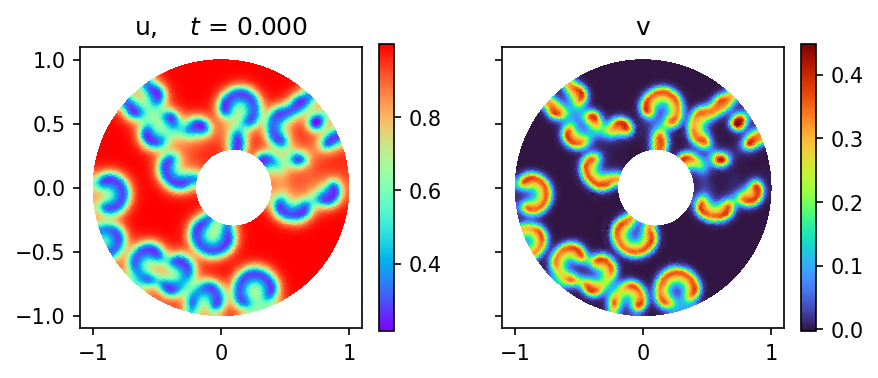

In [141]:

# looks good 
disp(mesh,gfu,0,xv,yv,tri_tt,refiner,'')  

In [142]:
gfu = ngsolve.GridFunction(fes) # to hold the solution 
mkinit(gfu,mesh,0.1,30,maxh_mesh)  # make initial conditions and show them
scene = Draw(gfu.components[1],mesh, settings = {  "Colormap" : { "ncolors" : 20 },"Objects" : {"Wireframe" : False} });  # 


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [103]:
D_u  = 2.0e-5;   D_v = D_u/2 #diffusion coefficients 
dt = 1    # timestep 
rdtype = 'GS'   # doing a Gray Scott reaction diffusion model 
invastar,a_lap,b_op,invm = mkops(fes,D_u,D_v,dt) # make ops
alpha = 0.028;  beta = 0.053 # choose some nice GS params 
d = 1.0-4*(alpha + beta)**2/alpha 
a_Hopf = 0.5* ( np.sqrt(beta) - 2*beta - np.sqrt(beta*(1-4*np.sqrt(beta))))
a_SN = (1.0/8.0) * (1 - 8*beta + 1 - np.sqrt(1.-16*beta))
print(d)
print(a_Hopf)
# op version works better! not sure why
gfut_CN = TimeStepping_CN(fes,gfu,scene,invastar, a_lap,invm, rdtype, alpha, beta, dt, tend=1000,\
                          reaction_by_hand = False,nsamples=300)
# seems to give temporal instability and occasionally patterns 

0.06271428571428572
0.029728346297986118
craete bilinearformapplication
 999

In [ ]:
a =0.022,
b =0.053,

In [129]:
gfu = ngsolve.GridFunction(fes) # to hold the solution 
mkinit(gfu,mesh,0.1,30,maxh_mesh)  # make initial conditions and show them
scene = Draw(gfu.components[1],mesh, settings = {  "Colormap" : { "ncolors" : 20 },"Objects" : {"Wireframe" : False} });  # 


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [130]:
D_u  = 2.0e-5;   D_v = D_u/2 #diffusion coefficients 
dt = 0.5   # timestep 
rdtype = 'GS'   # doing a Gray Scott reaction diffusion model 
invastar,a_lap,b_op,invm = mkops(fes,D_u,D_v,dt) # make ops
alpha = 0.022;  beta = 0.053 # choose some nice GS params 
# op version works better! not sure why
gfut_CN = TimeStepping_CN(fes,gfu,scene,invastar, a_lap,invm, rdtype, alpha, beta, dt, tend=1000,\
                          reaction_by_hand = False,nsamples=300)
# seems to give nice temporal instability and  patterns together donuts and spots growing 

craete bilinearformapplication
 999.5

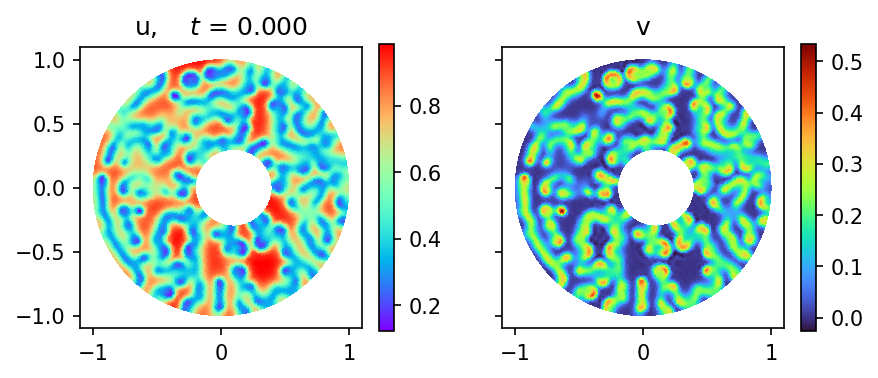

In [131]:
disp(mesh,gfu,0,xv,yv,tri_tt,refiner,'')  

In [106]:
D_u  = 2.0e-5;   D_v = D_u/2 #diffusion coefficients 
dt = 1    # timestep 
rdtype = 'GS'   # doing a Gray Scott reaction diffusion model 
invastar,a_lap,b_op,invm = mkops(fes,D_u,D_v,dt) # make ops
alpha = 0.022;  beta = 0.053 # choose some nice GS params 
# op version works better! not sure why
gfut_CN = TimeStepping_CN(fes,gfu,scene,invastar, a_lap,invm, rdtype, alpha, beta, dt, tend=1000,\
                          reaction_by_hand = True,nsamples=300)
# seems to give temporal instability and occasionally patterns 

 999